In [1]:
# default_exp data.eda

In [2]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 3.0 MB/s eta 0:00:01


# Exploratory Data Analysis 
>
>@danaderp 11.17.20 This is an exploratory data analysis for the codesearch net dataset. The goal of the exploration is to understand the code distribution of token information.
>

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
import functools 
from operator import or_
from collections import Counter
import datetime

In [7]:
import sentencepiece as spm

In [13]:
import pickle
from pathlib import Path

In [84]:
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import preprocessing

In [9]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Fixing parameters

In [15]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'hyper': {
            'seq_length':100,
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10
        },
        'tb_01':dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl',
        'tb_02':dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy.jsonl'
    }

In [16]:
params = params()

In [18]:
#tst
logging.info( params['tb_01'] )

2021-06-22 21:34:57,053 : INFO : ../dvc-icodegen/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl


## EDA Error Ratio Analysis (by Taxonomy)
This dataset is for testing purpuses

In [19]:
df_error_tax = pd.read_json(
            params['tb_01'], orient="records", lines=True
        )

2021-06-22 21:37:07,268 : INFO : Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2021-06-22 21:37:07,269 : INFO : Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-22 21:37:07,269 : INFO : NumExpr defaulting to 8 threads.


In [20]:
df_error_tax.head()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,code,x_treatment
0,0.0027,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0003,0.0000,0.0008,<private> <void> success<(>io.netty.channel.Ch...,False
1,0.0027,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0003,0.0000,0.0008,<private> <void> success<(>io.netty.channel.Ch...,True
2,0.0027,0.0,0.0001,0.0,0.0001,0.0001,0.0,0.0002,0.0000,0.0012,<private> <void> handleConnectRequest<(>com.as...,False
3,0.0027,0.0,0.0001,0.0,0.0001,0.0001,0.0,0.0002,0.0000,0.0012,<private> <void> handleConnectRequest<(>com.as...,True
4,0.0018,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0006,0.0004,0.0009,<@>java.lang.Override<n><protected> <void> onS...,False


In [34]:
potential_outcomes = ['y_blocks','y_exceptions','y_oop','y_tests','y_declarations','y_conditionals','y_loops','y_operators','y_datatypes','y_extra_tokens']

In [66]:
df_error_tax.describe()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
count,129444.000000,129444.000000,129444.000000,1.294440e+05,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000
mean,0.003048,0.000046,0.000220,6.968264e-07,0.000091,0.000115,0.000032,0.000437,0.000083,0.001052
std,0.000777,0.000094,0.000159,1.036152e-05,0.000089,0.000140,0.000067,0.000314,0.000130,0.000404
min,0.000100,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002500,0.000000,0.000100,0.000000e+00,0.000000,0.000000,0.000000,0.000200,0.000000,0.000800
50%,0.003000,0.000000,0.000200,0.000000e+00,0.000100,0.000100,0.000000,0.000400,0.000000,0.001000
75%,0.003600,0.000100,0.000300,0.000000e+00,0.000100,0.000200,0.000000,0.000600,0.000100,0.001300
max,0.009800,0.001100,0.002200,6.000000e-04,0.001500,0.001700,0.000800,0.009400,0.002000,0.003900


In [90]:
#Normalization
min_max_scaler = preprocessing.MinMaxScaler()
df_error_tax_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_error_tax[potential_outcomes]), columns = potential_outcomes)

In [99]:
df_error_tax_scaled['x_treatment'] = df_error_tax['x_treatment']

In [100]:
df_error_tax_scaled[potential_outcomes].describe()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
count,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000
mean,0.303967,0.041612,0.099847,0.001161,0.060522,0.067904,0.040290,0.046502,0.041278,0.269832
std,0.080139,0.085207,0.072262,0.017269,0.059579,0.082643,0.083303,0.033392,0.064873,0.103603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.247423,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.205128
50%,0.298969,0.000000,0.090909,0.000000,0.066667,0.058824,0.000000,0.042553,0.000000,0.256410
75%,0.360825,0.090909,0.136364,0.000000,0.066667,0.117647,0.000000,0.063830,0.050000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


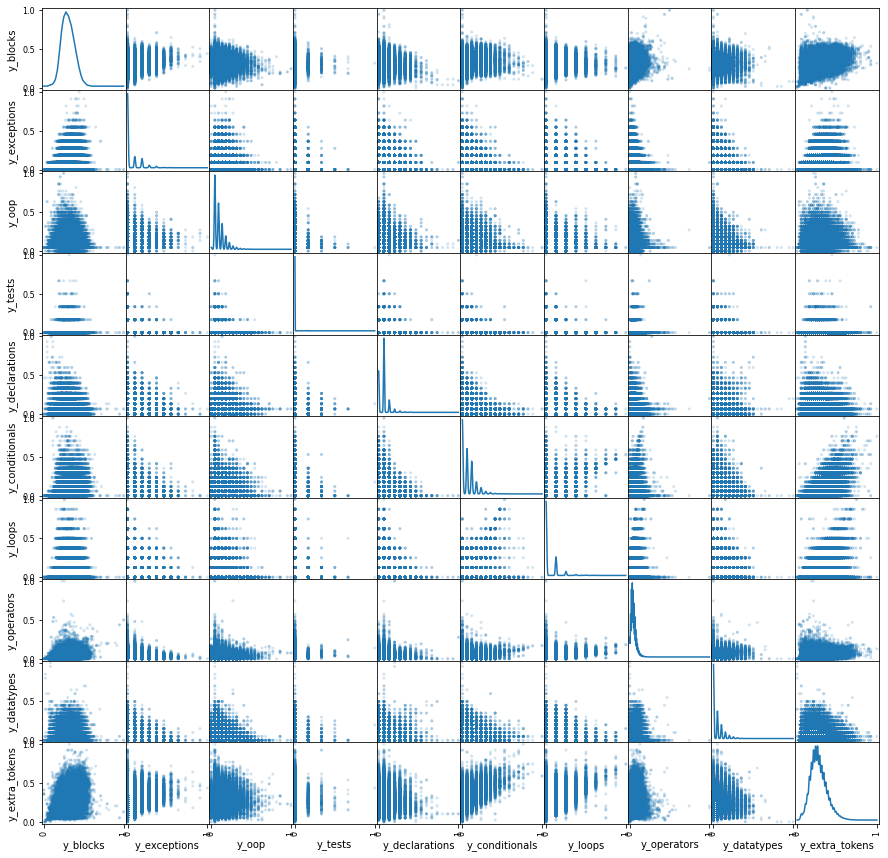

In [92]:
scatter_matrix(
    df_error_tax_scaled[potential_outcomes], 
    alpha=0.2, 
    figsize=(15, 15), 
    diagonal="kde"
);

array([[<AxesSubplot:title={'center':'y_blocks'}>,
        <AxesSubplot:title={'center':'y_exceptions'}>],
       [<AxesSubplot:title={'center':'y_oop'}>,
        <AxesSubplot:title={'center':'y_tests'}>],
       [<AxesSubplot:title={'center':'y_declarations'}>,
        <AxesSubplot:title={'center':'y_conditionals'}>],
       [<AxesSubplot:title={'center':'y_loops'}>,
        <AxesSubplot:title={'center':'y_operators'}>],
       [<AxesSubplot:title={'center':'y_datatypes'}>,
        <AxesSubplot:title={'center':'y_extra_tokens'}>]], dtype=object)

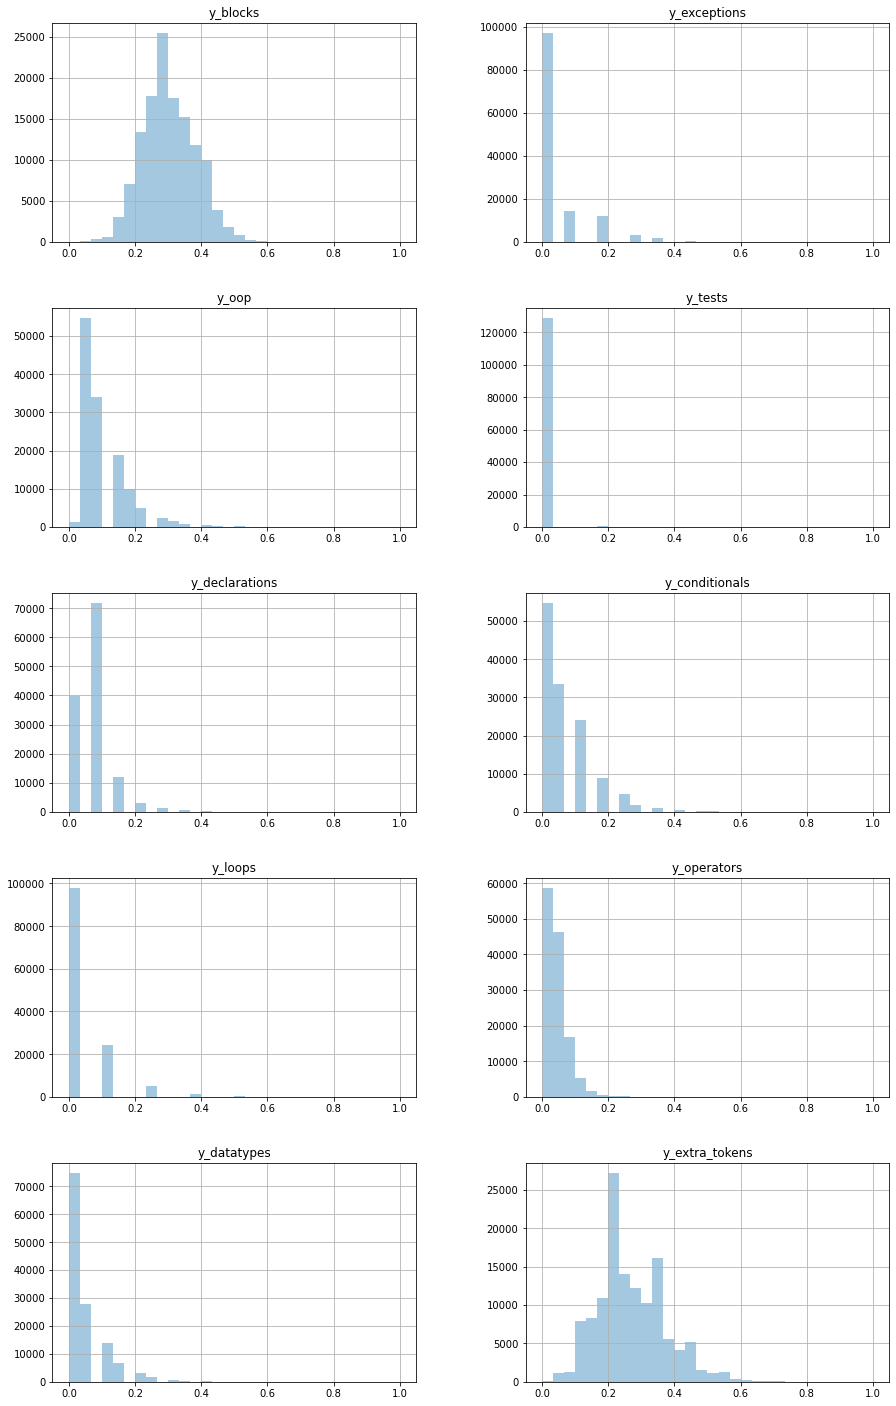

In [97]:
df_error_tax_scaled[potential_outcomes].hist(
    bins=30, 
    alpha=0.4, 
    layout=(5, 2), 
    figsize = (15,25)
)

<AxesSubplot:>

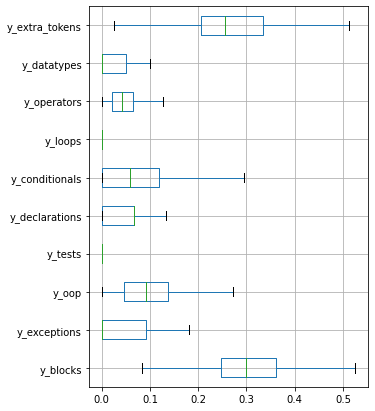

In [98]:
df_error_tax_scaled.boxplot(
    column=potential_outcomes,
    showfliers=False,
    vert=False,
    figsize=(5,7)
)

<AxesSubplot:>

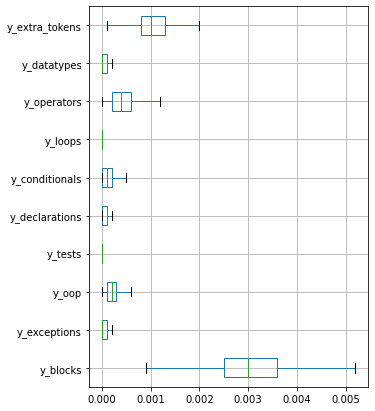

In [50]:
df_error_tax.boxplot(
    column=potential_outcomes,
    showfliers=False,
    vert=False,
    figsize=(5,7)
)

array([[<AxesSubplot:title={'center':'y_blocks'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_exceptions'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_oop'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_tests'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_declarations'}, xlabel='x_treatment'>],
       [<AxesSubplot:title={'center':'y_conditionals'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_loops'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_operators'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_datatypes'}, xlabel='x_treatment'>,
        <AxesSubplot:title={'center':'y_extra_tokens'}, xlabel='x_treatment'>]],
      dtype=object)

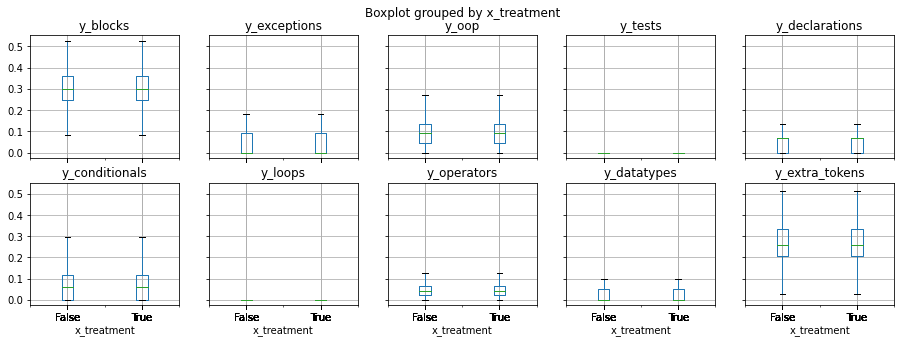

In [101]:
#Can we observe any significant difference between the error in bug and not buggy?
df_error_tax_scaled.boxplot(
    column=potential_outcomes, 
    showfliers=False, 
    #vert=False,
    layout=(2, 5), 
    figsize = (15,5),
    by="x_treatment"
)

## EDA Cross-Entropy Analysis
This dataset is for testing purpuses

In [104]:
df_cross_entr = pd.read_json(
            params['tb_02'], orient="records", lines=True
        )

ValueError: Expected object or value

In [60]:
df_cross_entr.head()

,code,y_cross_entropy,x_treatment
0,<private> <void> success<(>io.netty.channel.Ch...,6.006220,False
1,<private> <void> success<(>io.netty.channel.Ch...,6.008038,True
2,<private> <void> handleConnectRequest<(>com.as...,6.368741,False
3,<private> <void> handleConnectRequest<(>com.as...,6.337473,True
4,<@>java.lang.Override<n><protected> <void> onS...,3.927699,False


In [102]:
df_cross_entr.describe()

,y_cross_entropy
count,129444.000000
mean,6.142502
std,1.510858
min,2.066005
25%,5.038853
50%,5.982966
75%,7.085069
max,12.283474


<AxesSubplot:>

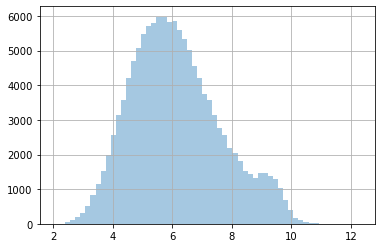

In [75]:
df_cross_entr['y_cross_entropy'].hist(
    bins=60, 
    alpha=0.4
)

<AxesSubplot:>

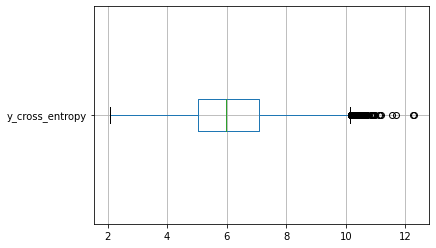

In [69]:
df_cross_entr.boxplot(
    column='y_cross_entropy',
    showfliers=True,
    vert=False,
    #figsize=(5,7)
)

<AxesSubplot:title={'center':'y_cross_entropy'}, xlabel='x_treatment'>

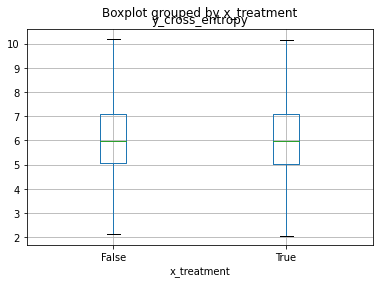

In [65]:
df_cross_entr.boxplot(
    column='y_cross_entropy',
    showfliers=False,
    by="x_treatment"
    #figsize=(5,7)
)

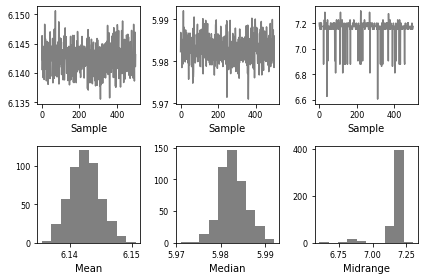

In [103]:
bootstrap_plot(
    df_cross_entr['y_cross_entropy'], 
    size=100000, 
    samples=500, 
    color="grey");

In [ ]:
#Avg Number of Subwords 
count_subwords = [len( eval(mtd) ) for mtd in df_train['code_tokens'].values]

In [ ]:
df_train['count_tokens'] = count_subwords

In [ ]:
#BPE 

# Descriptive Statistics

All Java Set

In [ ]:
java_df.describe()

,code_len,bpe32_len
count,467203.000000,467203.000000
mean,113.079653,146.274557
std,189.121245,303.804009
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,150.000000
max,27192.000000,52975.000000


All Java Partition

In [ ]:
df_train.describe()

,code_len,bpe32_len
count,384868.000000,384868.000000
mean,113.720826,147.151002
std,194.007951,313.904001
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,151.000000
max,27192.000000,52975.000000


In [ ]:
logging.info([ p.describe() for p in list_all_partitions])

2020-11-17 12:31:54,629 : INFO : [            code_len      bpe32_len
count  384868.000000  384868.000000
mean      113.720826     147.151002
std       194.007951     313.904001
min        20.000000      20.000000
25%        42.000000      50.000000
50%        67.000000      81.000000
75%       122.000000     151.000000
max     27192.000000   52975.000000,            code_len     bpe32_len
count  14605.000000  14605.000000
mean      94.331736    120.097843
std      115.802231    171.079255
min       21.000000     21.000000
25%       39.000000     46.000000
50%       59.000000     71.000000
75%      104.000000    127.000000
max     3099.000000   5747.000000,            code_len     bpe32_len
count  25011.000000  25011.000000
mean     114.274599    148.204710
std      166.432695    245.938732
min       21.000000     22.000000
25%       43.000000     52.000000
50%       69.000000     84.000000
75%      125.000000    155.000000
max     5685.000000  10015.000000,            code_len     bpe

In [ ]:
logging.info([ stats.median_absolute_deviation(p['code_len'].values) for p in list_all_partitions])

2020-11-17 12:29:30,408 : INFO : [45.9606, 37.065, 47.4432, 44.477999999999994]


Train Partition

In [ ]:
# Frequent Characters
train_tokens = df_train.code_tokens.values

In [ ]:
train_vocab_tokens = [ eval(method)  for method in train_tokens ] #Evaluating given tokens

In [ ]:
train_counter_tokens = [ Counter(method) for method in train_vocab_tokens ] #Counting the words

In [ ]:
train_counter = functools.reduce(lambda a,b : a+b, train_counter_tokens ) ## [Warning! Time Consuming]

In [ ]:
train_counter

NameError: name 'train_counter' is not defined

In [ ]:
#Persisting the counter object
with open(params['eda']+'['+ str(datetime.datetime.now()) +']-codesearchnet_token_counts.pickle', 'wb') as outputfile:
    pickle.dump( train_counter, outputfile )